cuda
tensor([451.4110,   8.0478,  35.4934,   1.7103, 322.2853], device='cuda:0')
tensor(81.8927, device='cuda:0')
500.00000000000006
tensor(0.1811, device='cuda:0')


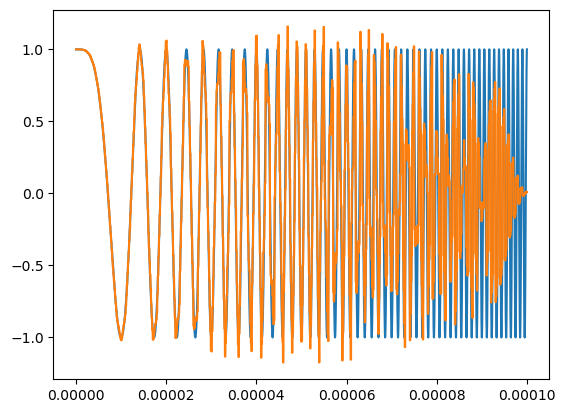

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
snr_db = 30
comm_pulse_kind = 'CDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
snr = 10**(snr_db/10)

if comm_pulse_kind=='OFDMA':
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
    sigma2 = L*Tb/snr

if comm_pulse_kind=='TDMA':
    g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
    sigma2 = L*Tb/snr/K

if comm_pulse_kind=='CDMA':
    g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])
    sigma2 = L*Tb/snr

if radar_pulse_kind=='LFM':
    radar_pulse = myRadarPulses.LFM_pulse(B)

if radar_pulse_kind=='Gaussian':
    radar_pulse = myRadarPulses.Gaussian_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
user_bit_energy = torch.sum(torch.abs(g_vec)**2, dim=1).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = radar_pulse.repeat(K*L, 1)

G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])

c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)
print(user_energy / sigma2)
print((c_opt.abs()**2).sum())

print(K*snr*sigma2/Tb)
print(torch.mean(torch.abs(s_opt - radar_pulse)**2))

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda
Iteration 0: constraint value = -49645.602, Dual Variable = 0.000, Cost = -29.928
	----> sumRate = 47.348, MSE = 4.424
Iteration 100: constraint value = -48801.016, Dual Variable = 0.000, Cost = -33.646
	----> sumRate = 56.135, MSE = 11.309
Iteration 200: constraint value = -48530.375, Dual Variable = 0.000, Cost = -34.128
	----> sumRate = 57.587, MSE = 12.779
Iteration 300: constraint value = -48421.516, Dual Variable = 0.000, Cost = -34.399
	----> sumRate = 58.080, MSE = 12.956
Iteration 400: constraint value = -48365.238, Dual Variable = 0.000, Cost = -34.587
	----> sumRate = 58.311, MSE = 12.858
Iteration 500: constraint value = -48330.535, Dual Variable = 0.000, Cost = -34.718
	----> sumRate = 58.445, MSE = 12.733
Iteration 600: constraint value = -48307.254, Dual Variable = 0.000, Cost = -34.811
	----> sumRate = 58.533, MSE = 12.631
Iteration 700: constraint value = -48291.082, Dual Variable = 0.000, Cost = -34.876
	----> sumRate = 58.593, MSE = 12.555
Iteration 800: constra

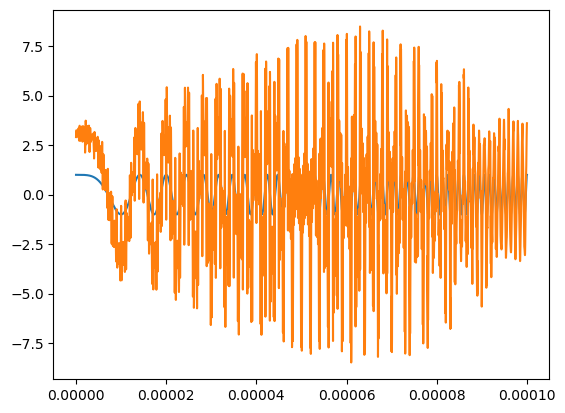

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from multiprocessing import Pool

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
# radar_pulse = myRadarPulses.Gaussian_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

def total_max_power_constr(coff):
     return torch.sum(torch.abs(coff)**2) - K*snr*sigma2/Tb*100

def get_mse(coff):
    s = torch.sum(coff[:, None] * g_vec, dim=0)
    return torch.mean(torch.abs(s - radar_pulse) ** 2) # Compute MSE loss

def get_gamma(coff):
    return (torch.abs(coff)**2).reshape((L, K)).sum(dim=0) * Tb / sigma2 #for OFDMA and CDMA

# Fitness function
def cost_function(coff, dual_lambda, theta):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """

    sumrate = torch.sum(torch.log2(1 + get_gamma(coff)))
    return theta*get_mse(coff) - (1-theta)*sumrate + dual_lambda*(total_max_power_constr(coff))

# Initialize individual with real and imaginary parts
init_c = torch.rand(K * L * 2, device=device, requires_grad=True) * 2 - 1
real_val = init_c[:len(init_c)//2]  # Real part
imag_val = init_c[len(init_c)//2:]  # Imaginary part
# Combine real and imaginary parts into complex tensor
c = real_val + 1j * imag_val  # Combine parts to form a complex number

c.retain_grad()

dual = 0
dual_update_rate = 1e-3
theta = 1/3
primal_update_rate = 5e-2 * theta * 10
for itr in range(10000):

    # Call the fitness function with the complex individual
    cost = cost_function(c, dual, theta)
    
    # Backpropagate to compute gradients
    cost.backward(retain_graph=True)
    delta_x = -c.grad
    t_coff = 1
    alpha = 0.005
    beta = 0.9

    with torch.no_grad():
        loop_cont = 0
        for _ in range(1000):
            loop_cont += 1
            new_cost = cost_function(c + t_coff*delta_x, dual, theta).item()
            old_cost = cost.item()
            if new_cost <= old_cost - alpha*t_coff*torch.sum(delta_x.abs()**2):
                break
            else:
                t_coff *= beta

        c += t_coff * delta_x  # Update rule
        dual = max(0, dual + dual_update_rate * total_max_power_constr(c))
        
        if itr % 100 == 0:
            print(f"Iteration {itr}: constraint value = {total_max_power_constr(c).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}")
            print(f'\t----> sumRate = {torch.sum(torch.log2(1 + get_gamma(c))).item():0.3f}, MSE = {get_mse(c).item():0.3f}')

    c.grad.zero_()    

c_opt = c.detach()
s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    N = len(individual) // 2
    # individual = np.clip(individual, -1, 1)
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    
    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val
    c_opt = c_opt.to(torch.complex64)
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    s_opt_normalized = s_opt
    radar_pulse_normalized = radar_pulse
    mse = (torch.mean(torch.abs(s_opt_normalized - radar_pulse_normalized) ** 2)).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)

# Genetic algorithm execution
population = toolbox.population(n=500)
n_generations = 1000

stats = Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", lambda a: np.mean(a))
stats.register("Min", lambda a: np.min(a))
# Run the genetic algorithm
result, log = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=True, stats=stats
)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
N = len(best_individual) // 2
real_val = torch.tensor(best_individual[:N], device=device, dtype=torch.float32)
imag_val = torch.tensor(best_individual[N:], device=device, dtype=torch.float32)

# Combine real and imaginary parts into complex tensor
c_opt_optimized = real_val + 1j * imag_val
c_opt_optimized = c_opt_optimized.to(torch.complex64).to(device)

# Synthesize optimized signal
s_opt_optimized = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
radar_pulse_power = (radar_pulse.abs()**2).sum()
s_opt_optimized2 = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0) * torch.sqrt(radar_pulse_power / (s_opt_optimized.abs()**2).sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized2.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
0.9**1000